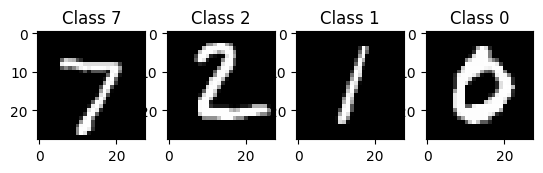

In [1]:
import numpy as np

import matplotlib.cm as cm
import matplotlib.pyplot as plt

from keras.datasets import mnist

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Add a channels dimension to the image sets as Akida expects 4-D inputs (corresponding to
# (num_samples, width, height, channels). Note: MNIST is a grayscale dataset and is unusual
# in this respect - most image data already includes a channel dimension, and this step will
# not be necessary.
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# Display a few images from the test set
f, axarr = plt.subplots(1, 4)
for i in range(0, 4):
    axarr[i].imshow(x_test[i].reshape((28, 28)), cmap=cm.Greys_r)
    axarr[i].set_title('Class %d' % y_test[i])
plt.show()

In [2]:
import keras

model_keras = keras.models.Sequential([
    keras.layers.Rescaling(1. / 255, input_shape=(28, 28, 1)),
    keras.layers.Conv2D(filters=32, kernel_size=3, strides=2),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    # Separable layer
    keras.layers.DepthwiseConv2D(kernel_size=3, padding='same', strides=2),
    keras.layers.Conv2D(filters=64, kernel_size=1, padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Flatten(),
    keras.layers.Dense(10)
], 'mnistnet')

model_keras.summary()



Model: "mnistnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 13, 13, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 13, 13, 32)        128       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 13, 13, 32)        0         
                                                                 
 depthwise_conv2d (Depthwis  (None, 7, 7, 32)          320       
 eConv2D)                                                        
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          2

In [3]:
from keras.optimizers import Adam

model_keras.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=Adam(learning_rate=1e-3),
    metrics=['accuracy'])

_ = model_keras.fit(x_train, y_train, epochs=10, validation_split=0.1)

Epoch 1/10


1688/1688 [==============================] - 12s 5ms/step - loss: 0.1698 - accuracy: 0.9490 - val_loss: 0.0839 - val_accuracy: 0.9762
Epoch 2/10
1688/1688 [==============================] - 9s 5ms/step - loss: 0.0750 - accuracy: 0.9766 - val_loss: 0.0713 - val_accuracy: 0.9783
Epoch 3/10
1688/1688 [==============================] - 9s 5ms/step - loss: 0.0518 - accuracy: 0.9832 - val_loss: 0.0694 - val_accuracy: 0.9827
Epoch 4/10
1688/1688 [==============================] - 9s 5ms/step - loss: 0.0420 - accuracy: 0.9866 - val_loss: 0.0580 - val_accuracy: 0.9843
Epoch 5/10
1688/1688 [==============================] - 9s 5ms/step - loss: 0.0338 - accuracy: 0.9887 - val_loss: 0.0606 - val_accuracy: 0.9842
Epoch 6/10
1688/1688 [==============================] - 9s 5ms/step - loss: 0.0285 - accuracy: 0.9903 - val_loss: 0.1031 - val_accuracy: 0.9717
Epoch 7/10
1688/1688 [==============================] - 8s 5ms/step - loss: 0.0249 - accuracy: 0.9915 - val_loss: 0.0644 - val_accura

In [4]:
score = model_keras.evaluate(x_test, y_test, verbose=0)
print('Test accuracy:', score[1])

Test accuracy: 0.986299991607666


In [5]:
from quantizeml.models import quantize, QuantizationParams

qparams = QuantizationParams(input_weight_bits=8, weight_bits=8, activation_bits=8)
model_quantized = quantize(model_keras, qparams=qparams)

c:\Users\xsb24130\AppData\Local\miniconda3\envs\akida-env\Lib\site-packages\onnxscript\converter.py:816: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
c:\Users\xsb24130\AppData\Local\miniconda3\envs\akida-env\Lib\site-packages\quantizeml\models\quantize.py:479: UserWarning: Quantizing per-axis with random calibration samples is not accurate. Set QuantizationParams.per_tensor_activations=True when calibrating with random samples.
  warnings.warn("Quantizing per-axis with random calibration samples is not accurate. "


1024/1024 [==============================] - 2s 2ms/step


In [6]:
model_quantized.summary()

Model: "mnistnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_input (InputLaye  [(None, 28, 28, 1)]       0         
 r)                                                              
                                                                 
 rescaling (QuantizedRescal  (None, 28, 28, 1)         0         
 ing)                                                            
                                                                 
 conv2d (QuantizedConv2D)    (None, 13, 13, 32)        320       
                                                                 
 re_lu (QuantizedReLU)       (None, 13, 13, 32)        64        
                                                                 
 depthwise_conv2d (Quantize  (None, 7, 7, 32)          384       
 dDepthwiseConv2D)                                               
                                                          

In [7]:
def compile_evaluate(model):
    """ Compiles and evaluates the model, then return accuracy score. """
    model.compile(metrics=['accuracy'])
    return model.evaluate(x_test, y_test, verbose=0)[1]


print('Test accuracy after 8-bit quantization:', compile_evaluate(model_quantized))


Test accuracy after 8-bit quantization: 0.98089998960495


In [8]:
model_quantized = quantize(model_keras, qparams=qparams,
                           samples=x_train, num_samples=1024, batch_size=100, epochs=2)

11/11 [==============================] - 0s 3ms/step


In [9]:
print('Test accuracy after calibration:', compile_evaluate(model_quantized))

Test accuracy after calibration: 0.9818000197410583


In [10]:
from cnn2snn import convert

model_akida = convert(model_quantized)
model_akida.summary()

                Model Summary                 
______________________________________________
Input shape  Output shape  Sequences  Layers
[28, 28, 1]  [1, 1, 10]    1          5     
______________________________________________

__________________________________________________________________
Layer (type)                        Output shape  Kernel shape  

=============== SW/conv2d-dequantizer_1 (Software) ===============

conv2d (InputConv2D)                [13, 13, 32]  (3, 3, 1, 32) 
__________________________________________________________________
depthwise_conv2d (DepthwiseConv2D)  [7, 7, 32]    (3, 3, 32, 1) 
__________________________________________________________________
conv2d_1 (Conv2D)                   [7, 7, 64]    (1, 1, 32, 64)
__________________________________________________________________
dense (Dense1D)                     [1, 1, 10]    (3136, 10)    
__________________________________________________________________
dequantizer_1 (Dequantizer)         [1,

In [11]:
accuracy = model_akida.evaluate(x_test, y_test)
print('Test accuracy after conversion:', accuracy)

# For non-regression purposes
assert accuracy > 0.96

Test accuracy after conversion: 0.9818000197410583


Input Label: 7


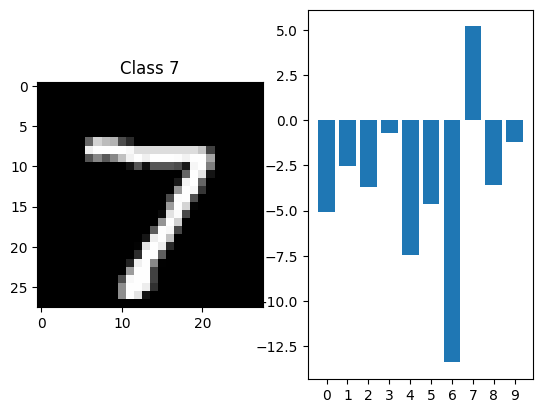

[ -5.089207   -2.5580308  -3.6717827  -0.7360458  -7.458494   -4.6605277
 -13.40793     5.185287   -3.5716538  -1.2163186]


In [12]:
# Test a single example
sample_image = 0
image = x_test[sample_image]
outputs = model_akida.predict(image.reshape(1, 28, 28, 1))
print('Input Label: %i' % y_test[sample_image])

f, axarr = plt.subplots(1, 2)
axarr[0].imshow(x_test[sample_image].reshape((28, 28)), cmap=cm.Greys_r)
axarr[0].set_title('Class %d' % y_test[sample_image])
axarr[1].bar(range(10), outputs.squeeze())
axarr[1].set_xticks(range(10))
plt.show()

print(outputs.squeeze())